In [237]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

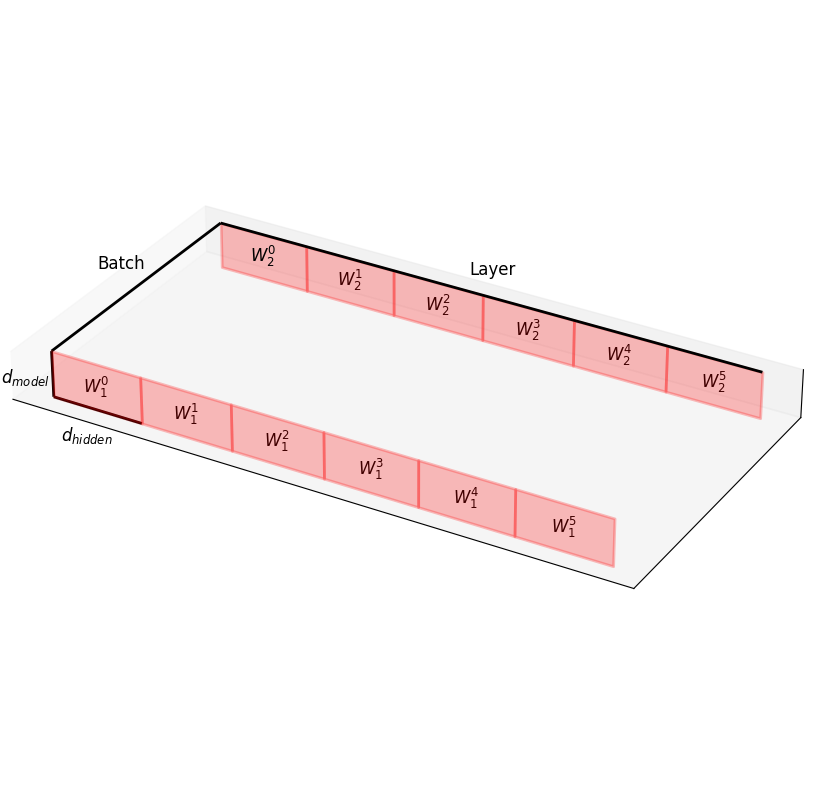

In [461]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

d_model = 8
d_hidden = 2*d_model
B = 48
L = 6

L_by_hidden_ax = 0
B_ax = 1
d_model_ax = 2

def make_face(ax, vals1, vals2, depth, dim1, dim2, name, color='b', alpha=0.25):
    dim3 = 3 - dim1 - dim2
    val1, val2 = np.meshgrid(vals1, vals2)
    val3 = np.full_like(val1, depth)
    arg = np.zeros((3, *val1.shape))
    arg[[dim1, dim2, dim3]] = val1, val2, val3
    face = ax.plot_surface(*arg, color=color, alpha=alpha, linewidth=2, edgecolor=color)
    textpos = np.zeros(3)
    textpos[[dim1, dim2, dim3]] = np.mean(vals1), np.mean(vals2), depth
    txt = ax.text(*textpos, name, color='k', fontsize=12, ha='center', va='center', alpha=4*alpha)
    return face, txt

def draw_arrow(ax, dimvals, val1s, val2s, label, dim, otherdim1, otherdim2):
    tail = np.zeros(3)
    vec = np.zeros(3)
    tail[[dim, otherdim1, otherdim2]] = dimvals[0], val1s[0], val2s[0]
    vec[[dim, otherdim1, otherdim2]] = dimvals[1], 0, 0
    ax.quiver(*tail, *vec, color='k', arrow_length_ratio=0.0, linewidth=2)
    text_pos = (tail + vec/2)
    text_pos[otherdim1] += val1s[1]
    text_pos[otherdim2] += val2s[1]
    ax.text(*text_pos, label, color='k', fontsize=12, ha='center', va='center')

residual_activations = []
hidden_activations = []
weights1 = []
weights2 = []
for l in range(L+1):
    residual_activations.append(make_face(ax, (0, d_model), (0, B), l*d_hidden, d_model_ax, B_ax, f'$x^{l}$', color='g', alpha=0.0))
    if l == L:
        break
    hidden_activations.append(make_face(ax, (l*d_hidden, (l+1)*d_hidden), (0, B), 0, L_by_hidden_ax, B_ax, f'$h^{l}$', color='g', alpha=0.0))
    weights1.append(make_face(ax, (l*d_hidden, (l+1)*d_hidden), (0, d_model), 0, L_by_hidden_ax, d_model_ax, f'$W_1^{l}$'))
    weights2.append(make_face(ax, (l*d_hidden, (l+1)*d_hidden), (0, d_model), B, L_by_hidden_ax, d_model_ax, f'$W_2^{l}$'))
draw_arrow(ax, (0, L*d_hidden), (d_model, 3), (B, 3), 'Layer', L_by_hidden_ax, d_model_ax, B_ax)
draw_arrow(ax, (0, d_hidden), (0, -3), (0, -3), '$d_{hidden}$', L_by_hidden_ax, d_model_ax, B_ax)
draw_arrow(ax, (0, B), (0, -3), (d_model, 3), 'Batch', B_ax, L_by_hidden_ax, d_model_ax)
draw_arrow(ax, (0, d_model), (0, -3), (0, -3), '$d_{model}$', d_model_ax, L_by_hidden_ax, B_ax)


width = L*d_hidden
ax.set_xlim3d(-3, width+3)
ax.set_aspect('equal')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

def set_color(obj, color):
    face, txt = obj
    face.set_alpha(0.25)
    face.set_color(color)
    txt.set_alpha(1.0)

def hide(obj):
    face, txt = obj
    face.set_alpha(0.0)
    face.set_color('w')
    txt.set_alpha(0.0)

def update_gen():
    yield
    set_color(residual_activations[0], 'g')
    yield
    for l in range(L):
        # Compute hidden activations.
        set_color(residual_activations[l], 'y')
        set_color(weights1[l], 'y')
        set_color(hidden_activations[l], 'g')
        yield
        set_color(residual_activations[l], 'g')
        set_color(weights1[l], 'b')

        # Compute residual activations.
        set_color(hidden_activations[l], 'y')
        set_color(weights2[l], 'y')
        set_color(residual_activations[l+1], 'g')
        yield
        set_color(hidden_activations[l], 'g')
        set_color(weights2[l], 'b')

    set_color(residual_activations[L], 'r')
    yield
    for l in range(L - 1, -1, -1):
        # Compute weight2 gradient.
        set_color(hidden_activations[l], 'y')
        set_color(residual_activations[l+1], 'y')
        set_color(weights2[l], 'r')
        yield
        set_color(hidden_activations[l], 'g')
        set_color(residual_activations[l+1], 'r')

        # Compute hidden activation gradient.
        set_color(weights2[l], 'y')
        set_color(residual_activations[l+1], 'y')
        set_color(hidden_activations[l], 'r')
        yield
        set_color(weights2[l], 'r')
        hide(residual_activations[l+1])

        # Compute weight1 gradient.
        set_color(residual_activations[l], 'y')
        set_color(hidden_activations[l], 'y')
        set_color(weights1[l], 'r')
        yield
        set_color(residual_activations[l], 'g')
        set_color(hidden_activations[l], 'r')

        # Compute residual activation gradient.
        if l == 0:
            hide(residual_activations[l])
        else:
            set_color(weights1[l], 'y')
            set_color(hidden_activations[l], 'y')
            set_color(residual_activations[l], 'r')
        yield
        set_color(weights1[l], 'r')
        hide(hidden_activations[l])
    yield
    yield
update_gen = update_gen()
def update(frame):
    return next(update_gen)

ani = FuncAnimation(fig, update, frames=range(6*L+3))
ani.save('batch.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
